In [1]:
from __future__ import division
import numpy as np
import matplotlib
from scipy.signal import welch, periodogram, butter, sosfiltfilt
from dynesty import NestedSampler
from dynesty.utils import resample_equal
import corner

font = {'weight' : 'bold', 'size'   : 12}

import matplotlib
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (8, 6)
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from src.makeLISAdata import LISAdata

### Now recover sigma in freq domain

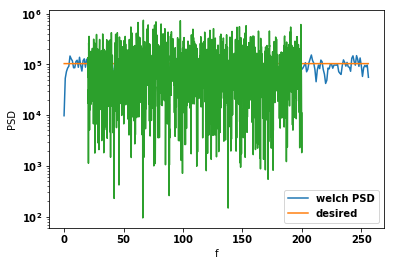

In [12]:
##First bandpass
def freq_domain(npos, nacc, fmin=10, fmax=100, fs=256, diagplot=0, dur=10, segDur=1):
    
    nperseg = int(fs*dur)

    
    ## determine pass band frequencies which are to be slightly higher
    fmin_pass, fmax_pass = int(0.5*fmin), int(1.1*fmax) 
    
    
    params= []
    inj = []
    ld = LISAdata(params, inj)
    
    
    ## Theoretical
    frange = np.arange(1.0/dur, fs/2.0, 1.0/dur)
    #Spos = n*(1.0/frange**alpha)
    Spos, Sacc = ld.fundamental_noise_spectrum(frange, Np=npos, Na=nacc) 
    
    ## Make gaussina data 
    data = ld.gaussianData(Spos, frange, fs=fs, dur=dur) + ld.gaussianData(Sacc, frange, fs=fs, dur=dur)


    ## FFT
    hwin = np.hanning(data.size)
    win_fact = np.mean(hwin**2)
    rtilda = np.sqrt(2/(dur*win_fact*fs**2)) * np.fft.rfft(data*hwin, n=nperseg)
    freqs = np.fft.rfftfreq(nperseg, d=1.0/fs)
    fidx = np.logical_and(freqs >= fmin, freqs <= fmax)
    freqs, rtilda = freqs[fidx], rtilda[fidx]

    rtilda = np.reshape(rtilda, (rtilda.size, 1))
    if diagplot:
        fi, si = welch(data, fs=fs, nperseg=int(fs))
        plt.semilogy(fi, si, label='welch PSD')
        plt.semilogy(frange, Spos + Sacc, label='desired')
        plt.legend()
        plt.semilogy(freqs, np.abs(rtilda)**2)
        #plt.ylim(3e-1, 20)
        plt.xlabel('f')
        plt.ylabel('PSD')
        
    return freqs, rtilda
#################################################################################

freqs, rtilda = freq_domain(npos=2, nacc=0.66, fmin=20, fmax=200, fs=512, diagplot=1, dur=10, segDur=1)

In [3]:
##First bandpass
def freq_domain_tf(npos, nacc, fmin=10, fmax=100, fs=256, diagplot=0, dur=10, segDur=1):
    
    ## determine pass band frequencies which are to be slightly higher
    fmin_pass, fmax_pass = int(0.5*fmin), int(1.1*fmax) 
    
    
    params= []
    inj = []
    ld = LISAdata(params, inj)
    
    
    ## Theoretical
    frange = np.arange(1.0/dur, fs/2.0, 1.0/dur)
    #Spos = n*(1.0/frange**alpha)
    Spos, Sacc = ld.fundamental_noise_spectrum(frange, Np=npos, Na=nacc) 
    
    ## Make gaussina data 
    data = ld.gaussianData(Spos, frange, fs=fs, dur=dur) + ld.gaussianData(Sacc, frange, fs=fs, dur=dur)

    ## FFT
    nperseg = int(fs*segDur)
    nsegs = int(dur/segDur) - 1
    
    hwin = np.hanning(nperseg)
    win_fact = np.mean(hwin**2)
    
    freqs = np.fft.rfftfreq(nperseg, d=1.0/fs)
    rtilda = np.zeros((freqs.size, nsegs), dtype='complex')
    
    for ii in range(nsegs):
        idxmin, idxmax = int(ii*nperseg), int((ii+1)*nperseg)
        rtilda[:, ii] = np.sqrt(2/(dur*win_fact*fs**2)) * np.fft.rfft(data[idxmin:idxmax]*hwin, n=nperseg)
  

    fidx = np.logical_and(freqs >= fmin, freqs <= fmax)
    freqs, rtilda = freqs[fidx], rtilda[fidx, :]


    if diagplot:
        fi, si = welch(data, fs=fs, nperseg=int(fs))
        plt.semilogy(fi, si, label='welch PSD')
        plt.semilogy(frange, Spos, label='desired')
        plt.legend()
        plt.semilogy(freqs, np.abs(rtilda)**2)
        #plt.ylim(3e-1, 20)
        plt.xlabel('f')
        plt.ylabel('PSD')
        
    return freqs, rtilda
#################################################################################

#freqs, rtilda = freq_domain(n=2, alpha=0.66, fmin=20, fmax=200, fs=512, diagplot=0, dur=100)

In [19]:
class Bayes():
    
    def __init__(self,npos,nacc,  fmin, fmax, fs, dur, segDur, doTF):
    
        self.dur, self.fs, self.segDur = dur, fs, segDur
        self.fmin, self.fmax = fmin, fmax
        self.npos_true, self.nacc_true = npos, nacc
        
        if doTF:
            self.freqs,self.rtilda = freq_domain_tf(npos=self.npos_true,nacc=self.nacc_true, \
                                                 fmin=self.fmin, fmax=self.fmax, fs=self.fs,\
                                                 diagplot=0, dur=self.dur, segDur=self.segDur)
        else:
            self.freqs,self.rtilda = freq_domain(npos=self.npos_true,nacc=self.nacc_true, \
                                             fmin=self.fmin, fmax=self.fmax, fs=self.fs,\
                                             diagplot=0, dur=self.dur, segDur=self.segDur)
    
    ## prior function
    def prior(self, theta):
    
        npos, nacc = theta

        return (np.log10(self.npos_true) + 2*npos - 1 , np.log10(self.nacc_true) + 2*nacc - 1 ) 
    
    ## likelihood
    def loglike(self, theta):
    
        npos, nacc = theta
        npos, nacc  = 10**npos, 10**nacc 
    
        Sh =  npos*(1 + (2e-3/self.freqs)**4) + \
              nacc*(1 + 16e-8/self.freqs**2)*(1 + (self.freqs/8e-3)**4)*(1.0/(2*np.pi*self.freqs)**4)
            
        loglike = -np.sum(np.abs(self.rtilda)**2/(Sh[:, None]) + np.log(2*np.pi*Sh[:, None]))
    
        return loglike

In [25]:
def analysis(dur=10, segDur=1, doTF=0):
    
    spectra = Bayes(npos=10**(-41.045), nacc=10**(-48.443), fmin=1e-4, \
                    fmax=1e-1, fs=0.5, dur=dur, segDur=segDur, doTF=0)
    
    #parameters = [r'$\alpha$', r'$S_h$' ]
    parameters = [r'$n_p$',  r'$n_a$'  ]
    npar = len(parameters)


    ## Run sampler
    engine = NestedSampler(spectra.loglike, spectra.prior, npar, bound='multi', sample='rwalk', nlive=200)
    engine.run_nested(dlogz=0.5,print_progress=True )

    # re-scale weights to have a maximum of one
    res = engine.results
    weights = np.exp(res['logwt'] - res['logz'][-1])
    weights[-1] = 1 - np.sum(weights[0:-1])

    post = resample_equal(res.samples, weights)
    truevals = [np.log10(spectra.npos_true), np.log10(spectra.nacc_true)]
    if 1:
        
        fig = corner.corner(post, range=[0.999]*npar, labels=parameters, quantiles=(0.16, 0.84),
                            smooth=None, smooth1d=0.8, show_titles=True,
                            title_kwargs={"fontsize": 12},label_kwargs={"fontsize": 14},
                            fill_contours=True, use_math_text=True, )
        fig.set_size_inches(10, 8)
        
        axes = np.array(fig.axes).reshape((npar, npar))
        
        for ii in range(npar):     
            ax = axes[ii, ii]
            ax.axvline(truevals[ii], color="g", label='true value')
        
        
    else:           

        for ii in range(npar):
            plt.subplots(npar, 1, ii + 1)
            plt.hist(post[:, ii], bins=25, histtype='step')
            plt.axvline(truevals[ii], color="g", label='true value')

##################################################

### Analaysis as a frequency series

iter: 2295+200 | bound: 220 | nc: 1 | ncall: 46058 | eff(%):  5.417 | loglstar:   -inf < 9146712.507 <    inf | logz: 9146701.921 +/-  0.231 | dlogz:  0.002 >  0.500            

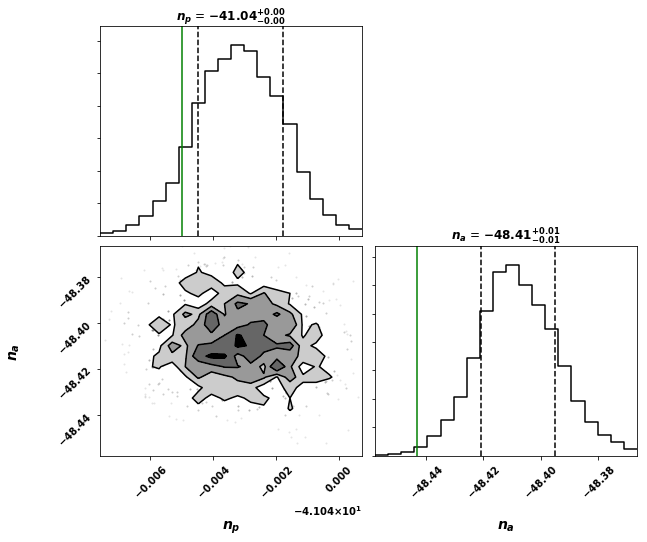

In [29]:
analysis(dur=1e6, segDur=5e4, doTF=0)

### Analysis on a spectrogram

iter: 2256+200 | bound: 208 | nc: 1 | ncall: 44413 | eff(%):  5.530 | loglstar:   -inf < 9147166.040 <    inf | logz: 9147155.652 +/-  0.213 | dlogz:  0.002 >  0.500            

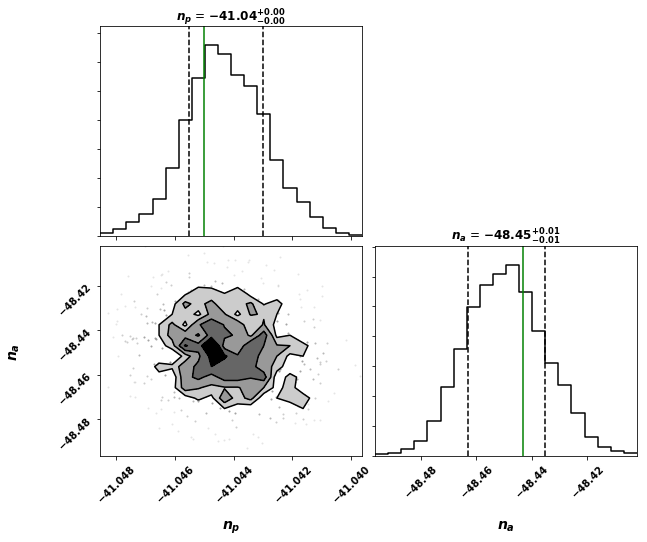

In [30]:
analysis(dur=1e6, segDur=5e4, doTF=1)